 **Initial setup**

mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


clone Mask R-CNN from github

In [2]:
%%shell
# clone Mask_RCNN repo and install packages
git clone https://github.com/matterport/Mask_RCNN
cd Mask_RCNN
python setup.py install 

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.76 MiB | 11.46 MiB/s, done.
Resolving deltas: 100% (566/566), done.
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build

setup Keras and TF

In [3]:
!pip install q keras==2.2.5
%tensorflow_version 1.x

     |████████████████████████████████| 337kB 3.5MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1
TensorFlow 1.x selected.


copy weights from project

In [4]:
%cd /content/drive/My Drive/Classroom/Proj1 - Buterfly/BFdataset/datasetV1

!cp mask_rcnn_balloon_0014.h5 /content/Mask_RCNN/mask_rcnn_butterfly.h5

/content/drive/My Drive/Classroom/Proj1 - Buterfly/BFdataset/datasetV1


copy training/validating data

In [5]:
%mkdir /content/Mask_RCNN/dataset/
%mkdir /content/Mask_RCNN/dataset/train/
%mkdir /content/Mask_RCNN/dataset/val/

%cd /content/drive/My Drive/Classroom/Proj1 - Buterfly/BFdataset/datasetV1/val
%cp -av * /content/Mask_RCNN/dataset/val/

%cd /content/drive/My Drive/Classroom/Proj1 - Buterfly/BFdataset/datasetV1/train
%cp -av * /content/Mask_RCNN/dataset/train/


/content/drive/My Drive/Classroom/Proj1 - Buterfly/BFdataset/datasetV1/val
'monarch_0021.jpg' -> '/content/Mask_RCNN/dataset/val/monarch_0021.jpg'
'monarch_0022.jpg' -> '/content/Mask_RCNN/dataset/val/monarch_0022.jpg'
'monarch_0023.jpg' -> '/content/Mask_RCNN/dataset/val/monarch_0023.jpg'
'monarch_0024.jpg' -> '/content/Mask_RCNN/dataset/val/monarch_0024.jpg'
'monarch_0025.jpg' -> '/content/Mask_RCNN/dataset/val/monarch_0025.jpg'
'via_region_data.json' -> '/content/Mask_RCNN/dataset/val/via_region_data.json'
/content/drive/My Drive/Classroom/Proj1 - Buterfly/BFdataset/datasetV1/train
'monarch_0001.jpg' -> '/content/Mask_RCNN/dataset/train/monarch_0001.jpg'
'monarch_0002.jpg' -> '/content/Mask_RCNN/dataset/train/monarch_0002.jpg'
'monarch_0003.jpg' -> '/content/Mask_RCNN/dataset/train/monarch_0003.jpg'
'monarch_0004.jpg' -> '/content/Mask_RCNN/dataset/train/monarch_0004.jpg'
'monarch_0005.jpg' -> '/content/Mask_RCNN/dataset/train/monarch_0005.jpg'
'monarch_0006.jpg' -> '/content/Mask_R

# Butterfly detection using Mask R-CNN

In [6]:
%cd /content/Mask_RCNN

!cp /content/Mask_RCNN/samples/balloon/balloon.py ./butterfly.py

!sed -i -- 's/balloon/butterfly/g' butterfly.py
!sed -i -- 's/Balloon/Butterfly/g' butterfly.py
!sed -i -- 's/epochs=30/epochs=5/g' butterfly.py

/content/Mask_RCNN


In [7]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append("./Mask_RCNN/")  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import butterfly 

%matplotlib inline 


# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


update path of weights

In [8]:
Butterfly_WEIGHTS_PATH = "/content/Mask_RCNN/mask_rcnn_butterfly.h5"

In [9]:
config = butterfly.ButterflyConfig()
Butterfly_DIR = os.path.join(ROOT_DIR, "/content/Mask_RCNN/dataset")

In [19]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
DEVICE = "/gpu:0"
TEST_MODE = "inference"
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [20]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [21]:
# Load validation dataset
dataset = butterfly.ButterflyDataset()
dataset.load_butterfly(Butterfly_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 5
Classes: ['BG', 'butterfly']


In [22]:
MODEL_DIR = "/content/Mask_RCNN"

# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [23]:
print("Loading weights ", Butterfly_WEIGHTS_PATH)
model.load_weights(Butterfly_WEIGHTS_PATH, by_name=True)

Loading weights  /content/Mask_RCNN/mask_rcnn_butterfly.h5


image ID: butterfly.monarch_0023.jpg (2) /content/Mask_RCNN/dataset/val/monarch_0023.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  237.00000  max:  763.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


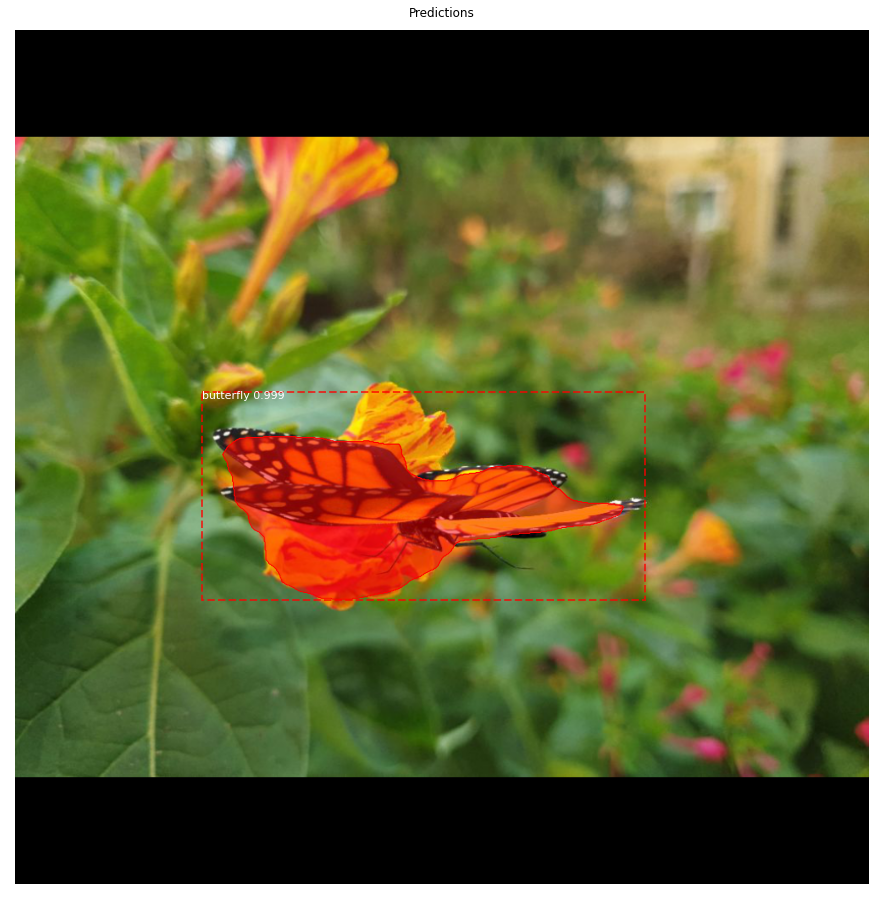

In [24]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)